<a id = "top"></a>

# Topic Modeling with Latent Dirichlet Allocation
---

This notebook descibes the process by which I use topic modeling with latent Dirichlet allocation to identify "topic anomalies". These can be used to highlight based on what the topic of chat is at that moment in time. For example, if I only wanted to see the funniest moments I could highlight solely based on the topic that the LDA algorithm decided was the "funny" topic. I could do the same thing for an "exciting" topic if I wanted to see the most pivotal plays across the entire stream. Determining the topic is primarily done with emotes, which convey a variety of emotions and generally show up next to each other within the spikes in activity. 

Some preprocessing and model fitting code was written with the help of this article:
>https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24

**This Notebook:**

- [Preprocessing](#pre)
- [LDA Fitting](#fit)
- [Plotting](#plot)

**Other Notebooks:**

- [Data Gathering and Formatting](01_data_gathering.ipynb)
- [Anomaly Detection](02_anomaly_detection.ipynb)
- [Video Editing](04_video_editing.ipynb)

### Importing 
---

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gensim
import nltk
import highlighter as hl

from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
from gensim import corpora, models

from pandas.plotting import register_matplotlib_converters

# Matplotlib has an issue with pandas datetime converters
register_matplotlib_converters()
pd.options.mode.chained_assignment = None

np.random.seed(35)

nltk.download('wordnet')

[nltk_data] Error loading wordnet: <urlopen error [Errno 8] nodename
[nltk_data]     nor servname provided, or not known>


False

In [2]:
data = pd.read_csv("../data/formatted/admiralbulldog_4_30.csv", 
                   index_col = "time", 
                   parse_dates = True)

data.head(5)

,username,channel,message
time,,,
2019-04-30 08:56:59,collectcalled,admiralbulldog,IF HENRIK WAS AN AniMAL
2019-04-30 08:56:59,laudon,admiralbulldog,gachiHYPER
2019-04-30 08:57:00,hyper_brah,admiralbulldog,WutFace WutFace WutFace WutFace WutFace WutFac...
2019-04-30 08:57:00,felianjo,admiralbulldog,"I LOVE THEM, JUST LET THEM IN CAGES Pepega Clap"
2019-04-30 08:57:00,nevervvinterr,admiralbulldog,gachiHYPER


<a id = "pre"></a>
## Preprocessing
---

[Back to top](#top)

In [3]:
# Stack all messages for one second onto the same second

documents = pd.DataFrame()

for sec in data.index.unique():
    
    documents = documents.append(
        {"doc": " ".join(data[data.index == sec]["message"].to_list())},
        ignore_index = True
    )
    
documents.index = data.index.unique()

In [4]:
documents.head()

,doc
time,
2019-04-30 08:56:59,IF HENRIK WAS AN AniMAL gachiHYPER
2019-04-30 08:57:00,WutFace WutFace WutFace WutFace WutFace WutFac...
2019-04-30 08:57:01,AYAYA
2019-04-30 08:57:02,gachiBASS gachiBASS
2019-04-30 08:57:03,gachiHYPER Jebaited gachiGASM


In [5]:
# Stack messages by 5 seconds; this data is used to train the 
# LDA model. Stacking up the messages gives the LDA more
# "context" words to work with. The idea is that what is 
# talked about in chat is roughly the same from second to 
# second so stacking a few seconds together should give better 
# results from the topic model.

roll = 5
documents_5 = [" ".join(documents[i:i + roll]["doc"]) for i in range(0, documents.shape[0], roll)]

In [6]:
# Construct a "rolling sum", or rolling concatenation of all 
# the chat messages. This is what the LDA model will be evaluated
# on. The resulting scores will be used to extract topics from
# the message per second data.

roll = 5
documents_rolling = [" ".join(documents[i:i + roll]["doc"]) for i in range(0, documents.shape[0])]

documents_rolling = pd.Series(documents_rolling, index = documents.index)

documents_rolling.head()

time
2019-04-30 08:56:59    IF HENRIK WAS AN AniMAL gachiHYPER WutFace Wut...
2019-04-30 08:57:00    WutFace WutFace WutFace WutFace WutFace WutFac...
2019-04-30 08:57:01    AYAYA gachiBASS gachiBASS gachiHYPER Jebaited ...
2019-04-30 08:57:02    gachiBASS gachiBASS gachiHYPER Jebaited gachiG...
2019-04-30 08:57:03    gachiHYPER Jebaited gachiGASM CUTE WABBIT AYAY...
dtype: object

In [7]:
# Function to stem and remove punctuation from the 
# text, returning a list of strings.

def preprocess(text):
    
    result = []
    
    for token in gensim.utils.simple_preprocess(text):
        
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 2:
            
            token = WordNetLemmatizer().lemmatize(token, pos='v')
            result.append(SnowballStemmer("english").stem(token))
            
    return result

In [8]:
# Testing the preprocessor on the first entry

doc_sample = documents_5[0]

print('Original document: ')

words = [word for word in doc_sample.split(' ')]
    
print(words)

print()

print('Processed document: ')

print(preprocess(doc_sample))

Original document: 
['IF', 'HENRIK', 'WAS', 'AN', 'AniMAL', 'gachiHYPER', 'WutFace', 'WutFace', 'WutFace', 'WutFace', 'WutFace', 'WutFace', 'WutFace', 'I', 'LOVE', 'THEM,', 'JUST', 'LET', 'THEM', 'IN', 'CAGES', 'Pepega', 'Clap', 'gachiHYPER', 'AYAYA', 'gachiBASS', 'gachiBASS', 'gachiHYPER', 'Jebaited', 'gachiGASM']

Processed document: 
['henrik', 'anim', 'gachihyp', 'wutfac', 'wutfac', 'wutfac', 'wutfac', 'wutfac', 'wutfac', 'wutfac', 'love', 'let', 'cage', 'pepega', 'clap', 'gachihyp', 'ayaya', 'gachibass', 'gachibass', 'gachihyp', 'jebait', 'gachigasm']


In [9]:
# Processing all the documents. .map requires a pandas series

processed_docs = pd.Series(documents_5).map(preprocess)
# processed_docs = documents['doc'].map(preprocess)
processed_docs.head()

0    [henrik, anim, gachihyp, wutfac, wutfac, wutfa...
1    [cute, wabbit, ayaya, gachihyp, usagi, ayayaup...
2    [flooooof, head, head, poop, actual, anim, cru...
3    [hotpokket, lay, cirpat, mingle, animal, like,...
4    [cmonbruh, genet, minglul, bruh, isnt, tortur,...
dtype: object

In [10]:
len(processed_docs)

1791

In [11]:
# Putting the words into gensim dictionary and filtering

dictionary = gensim.corpora.Dictionary(processed_docs)



# The total words is kept rather low at 1000; this is 
# because there are not that many emotes on twitch, 
# which are the primary indicator of the topic. This 
# could probably be lowered even further.

dictionary.filter_extremes(no_below = 5, no_above = 0.5, keep_n = 1000)

In [12]:
# Transforming all of the processed documents into
# a bag-of-words vector to be fed into the LDA model.

bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
bow_corpus[200]

[(2, 1),
 (19, 2),
 (21, 1),
 (49, 2),
 (59, 3),
 (60, 1),
 (61, 1),
 (81, 3),
 (316, 1),
 (486, 1),
 (518, 1),
 (519, 1),
 (521, 1)]

In [13]:
# print out one document and its term frequencies

bow_doc = bow_corpus[200]

for i in range(len(bow_doc)):
    
    print("Word {} \"{}\" appears {} time(s).".format(bow_doc[i][0], 
                                               dictionary[bow_doc[i][0]], 
                                               bow_doc[i][1]))

Word 2 "clap" appears 1 time(s).
Word 19 "lulw" appears 2 time(s).
Word 21 "admiralbulldog" appears 1 time(s).
Word 49 "pog" appears 2 time(s).
Word 59 "pogu" appears 3 time(s).
Word 60 "wtff" appears 1 time(s).
Word 61 "fathead" appears 1 time(s).
Word 81 "poggi" appears 3 time(s).
Word 316 "admiralcpl" appears 1 time(s).
Word 486 "leav" appears 1 time(s).
Word 518 "poke" appears 1 time(s).
Word 519 "pokelawl" appears 1 time(s).
Word 521 "hunter" appears 1 time(s).


<a id = "fit"></a>

## Fitting the Bag-of-Words LDA
---

Although LDA is normally done with TF-IDF, I chose to use BOW in the interest of interpretability. This ended up not being an issue as the input has no bearing on post-fit interpretability. Given more time to compare results, I would likely have gone with TF-IDF. As it stands, the model is highly sensitive to copypasta and one-man-spam; when the chat is slow and no single topic dominates, if one person in chat sends a chat message with a lot of emotes that are highly correlated with one topic, then the model would likely flag that erroneously. 

[Back to top](#top)

In [14]:
# Fit the model; this may take a minute,
# depending on the number of passes.

lda_model = gensim.models.LdaMulticore(bow_corpus, 
                                       num_topics = 16, 
                                       id2word = dictionary, 
                                       passes = 5, 
                                       workers = 2)

# Print out the topics and its associated words.
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))
    print()

Topic: 0 
Words: 0.235*"omegalul" + 0.116*"lulw" + 0.090*"lul" + 0.073*"pepelaugh" + 0.033*"trihard" + 0.017*"miss" + 0.016*"morph" + 0.012*"bulldog" + 0.011*"clock" + 0.010*"bruh"

Topic: 1 
Words: 0.163*"gachihyp" + 0.110*"ricardoflick" + 0.089*"hyperclap" + 0.043*"believ" + 0.040*"gachigasm" + 0.035*"clap" + 0.030*"handsup" + 0.018*"lulw" + 0.016*"omegalul" + 0.015*"gachi"

Topic: 2 
Words: 0.147*"pepega" + 0.070*"cycycyweebsout" + 0.069*"lulw" + 0.038*"chikin" + 0.038*"fri" + 0.024*"omegalul" + 0.021*"punoko" + 0.015*"cycycypedo" + 0.014*"save" + 0.014*"star"

Topic: 3 
Words: 0.089*"lul" + 0.071*"pepelaugh" + 0.064*"lulw" + 0.054*"anel" + 0.048*"win" + 0.031*"bettor" + 0.031*"omegalul" + 0.028*"clap" + 0.025*"movi" + 0.023*"sobay"

Topic: 4 
Words: 0.118*"pepegashak" + 0.101*"lulw" + 0.058*"pepehand" + 0.035*"omegalul" + 0.033*"jimmydorri" + 0.027*"pepelaugh" + 0.024*"jimmi" + 0.022*"blessrng" + 0.022*"lul" + 0.020*"monkah"

Topic: 5 
Words: 0.469*"trikool" + 0.464*"claphd" + 0.01

In [23]:
# You can use this to determine what topic an 
# unseen document will be classified as.
# This example has a few twitch "laughing"
# emotes to demonstrate that topic 0 is 
# the "funny" topic

unseen_document = "lul lulw omegalul"

bow_vector = dictionary.doc2bow(preprocess(unseen_document))

for index, score in sorted(lda_model[bow_vector], key = lambda tup: -1 * tup[1]):

    print(f"Score: {score} \t Topic {index}: {lda_model.print_topic(index, 5)}\n")

Score: 0.7656247019767761 	 Topic 0: 0.235*"omegalul" + 0.116*"lulw" + 0.090*"lul" + 0.073*"pepelaugh" + 0.033*"trihard"

Score: 0.01562502607703209 	 Topic 3: 0.089*"lul" + 0.071*"pepelaugh" + 0.064*"lulw" + 0.054*"anel" + 0.048*"win"

Score: 0.01562502421438694 	 Topic 4: 0.118*"pepegashak" + 0.101*"lulw" + 0.058*"pepehand" + 0.035*"omegalul" + 0.033*"jimmydorri"

Score: 0.01562502048909664 	 Topic 2: 0.147*"pepega" + 0.070*"cycycyweebsout" + 0.069*"lulw" + 0.038*"chikin" + 0.038*"fri"

Score: 0.015625018626451492 	 Topic 6: 0.069*"wine_glass" + 0.050*"feelsokayman" + 0.047*"monkagiga" + 0.042*"lulw" + 0.039*"clap"

Score: 0.015625018626451492 	 Topic 8: 0.110*"weirdchamp" + 0.058*"phase" + 0.049*"bruh" + 0.038*"spam" + 0.037*"cmonbruh"

Score: 0.015625018626451492 	 Topic 10: 0.130*"pepelaugh" + 0.111*"pog" + 0.081*"wtff" + 0.081*"pepehand" + 0.041*"pogu"

Score: 0.015625016763806343 	 Topic 1: 0.163*"gachihyp" + 0.110*"ricardoflick" + 0.089*"hyperclap" + 0.043*"believ" + 0.040*"gac

In [16]:
# Find the score for every string in the rolling sum
# and append those to a placeholder dataframe

df = pd.DataFrame()

for doc in documents_rolling:

    bow_vector = dictionary.doc2bow(preprocess(doc))
    
    scores = pd.DataFrame(lda_model[bow_vector], columns = ["topic", "score"])
    scores = scores.set_index("topic")
    
    df = pd.concat([df, scores.T], axis = 0)

In [17]:
df.shape

(8951, 16)

In [18]:
documents.shape

(8951, 1)

In [24]:
# Merge the scores with the messages and 
# fill the null values with zeros.

df.index = documents.index

docs_with_scores = pd.merge(documents, df, left_index = True, right_index = True)

docs_with_scores = docs_with_scores.fillna(0)

docs_with_scores.head()

,doc,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
time,,,,,,,,,,,,,,,,,
2019-04-30 08:56:59,IF HENRIK WAS AN AniMAL gachiHYPER,0.0,0.142809,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.103137,0.715363
2019-04-30 08:57:00,WutFace WutFace WutFace WutFace WutFace WutFac...,0.0,0.208422,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.149131,0.605510
2019-04-30 08:57:01,AYAYA,0.0,0.554670,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.122106,0.0,0.0,0.249352,0.000000
2019-04-30 08:57:02,gachiBASS gachiBASS,0.0,0.619582,0.0,0.0,0.0,0.078141,0.0,0.0,0.0,0.0,0.0,0.096095,0.0,0.0,0.148483,0.000000
2019-04-30 08:57:03,gachiHYPER Jebaited gachiGASM,0.0,0.593228,0.0,0.0,0.0,0.078361,0.0,0.0,0.0,0.0,0.0,0.092752,0.0,0.0,0.177961,0.000000


In [25]:
docs_with_scores.isna().sum().sum()

0

In [29]:
# Import time series data, as it has an index for every second

time_series = pd.read_csv("../data/formatted/admiralbulldog_4_30_mps.csv", 
                          index_col = "Unnamed: 0",
                          parse_dates = True).rename(columns = {"0": "mps"})

time_series.head()

,mps
2019-04-30 08:57:00,3
2019-04-30 08:57:01,1
2019-04-30 08:57:02,2
2019-04-30 08:57:03,3
2019-04-30 08:57:04,2


In [30]:
# Merge everything together in the most ambitious crossover event in history

time_series = pd.merge(time_series, docs_with_scores, how = "left", left_index = True, right_index = True)

time_series.head(6)

,mps,doc,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
2019-04-30 08:57:00,3,WutFace WutFace WutFace WutFace WutFace WutFac...,0.0,0.208422,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.149131,0.60551
2019-04-30 08:57:01,1,AYAYA,0.0,0.554670,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.122106,0.0,0.0,0.249352,0.00000
2019-04-30 08:57:02,2,gachiBASS gachiBASS,0.0,0.619582,0.0,0.0,0.0,0.078141,0.0,0.0,0.0,0.0,0.0,0.096095,0.0,0.0,0.148483,0.00000
2019-04-30 08:57:03,3,gachiHYPER Jebaited gachiGASM,0.0,0.593228,0.0,0.0,0.0,0.078361,0.0,0.0,0.0,0.0,0.0,0.092752,0.0,0.0,0.177961,0.00000
2019-04-30 08:57:04,2,CUTE WABBIT AYAYA gachiHYPER,0.0,0.535134,0.0,0.0,0.0,0.093785,0.0,0.0,0.0,0.0,0.0,0.112265,0.0,0.0,0.190625,0.00000
2019-04-30 08:57:05,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
# Filling null values with empty strings and zeros.

time_series["doc"].fillna(" ", inplace = True)

time_series.fillna(0, inplace = True)

time_series.head(6)

,mps,doc,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
2019-04-30 08:57:00,3,WutFace WutFace WutFace WutFace WutFace WutFac...,0.0,0.208422,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.149131,0.60551
2019-04-30 08:57:01,1,AYAYA,0.0,0.554670,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.122106,0.0,0.0,0.249352,0.00000
2019-04-30 08:57:02,2,gachiBASS gachiBASS,0.0,0.619582,0.0,0.0,0.0,0.078141,0.0,0.0,0.0,0.0,0.0,0.096095,0.0,0.0,0.148483,0.00000
2019-04-30 08:57:03,3,gachiHYPER Jebaited gachiGASM,0.0,0.593228,0.0,0.0,0.0,0.078361,0.0,0.0,0.0,0.0,0.0,0.092752,0.0,0.0,0.177961,0.00000
2019-04-30 08:57:04,2,CUTE WABBIT AYAYA gachiHYPER,0.0,0.535134,0.0,0.0,0.0,0.093785,0.0,0.0,0.0,0.0,0.0,0.112265,0.0,0.0,0.190625,0.00000
2019-04-30 08:57:05,0,,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.00000


<a id = "plot"></a>
## Plotting
---

[Back to top](#top)

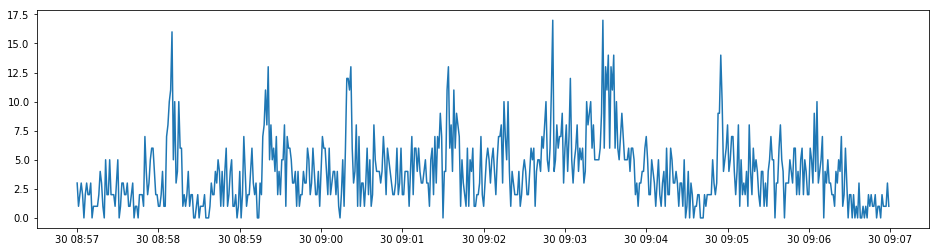

In [34]:
plt.figure(figsize = (16,4))
plt.plot(time_series["mps"][0:600]);

> First ten minutes of raw data, for reference.

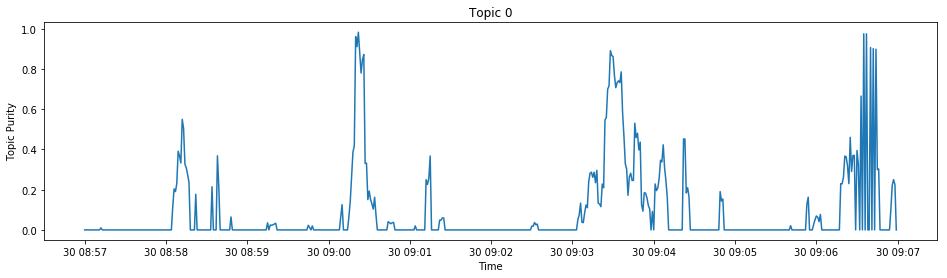

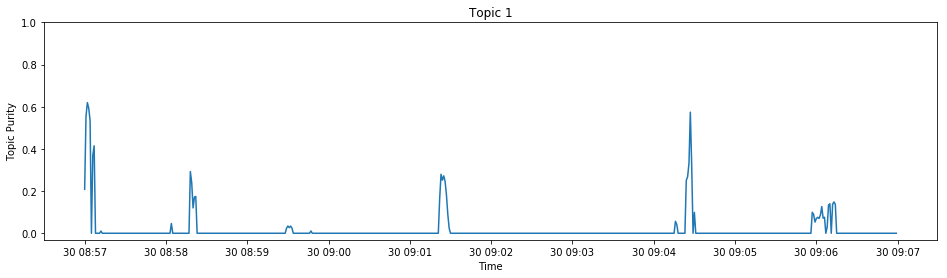

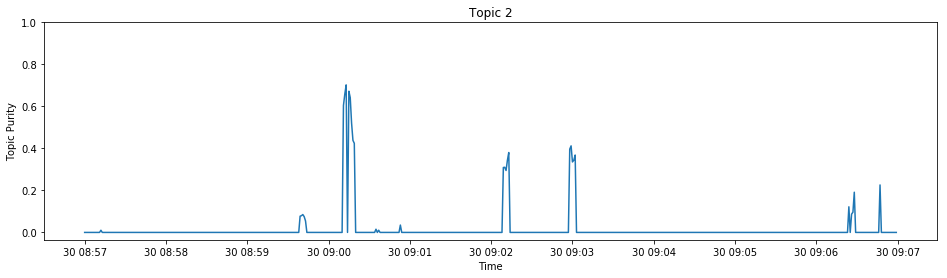

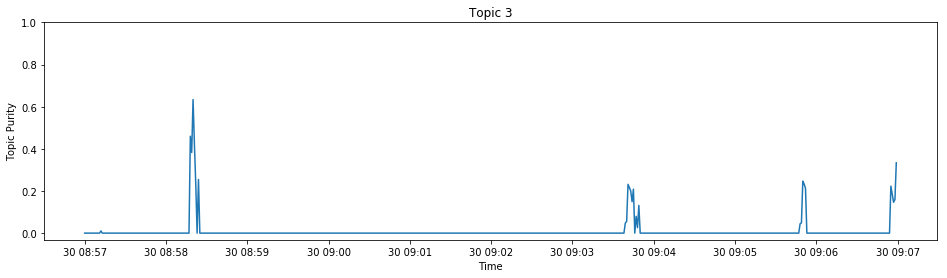

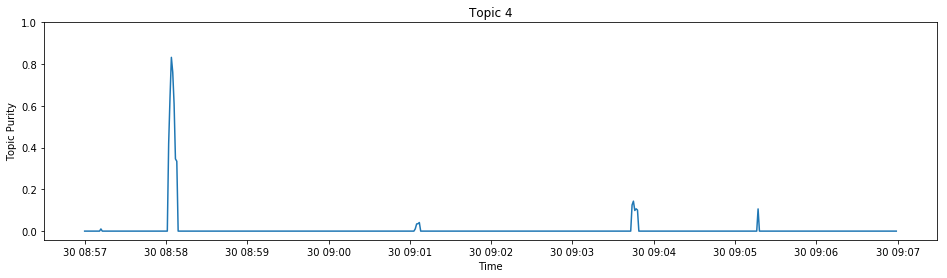

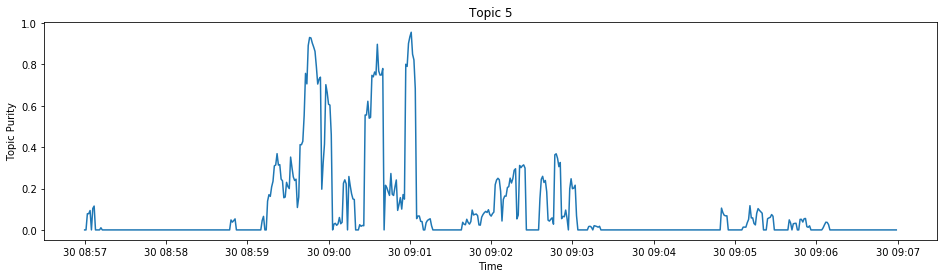

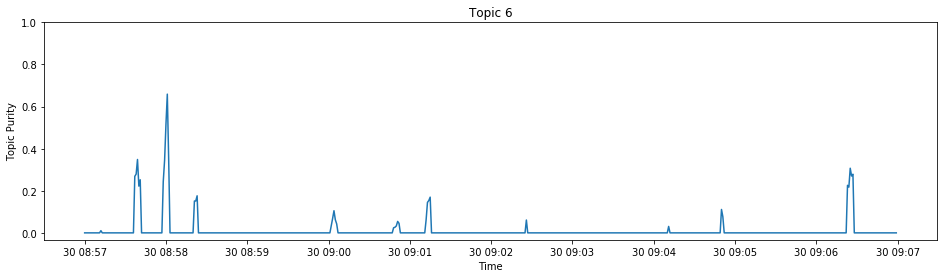

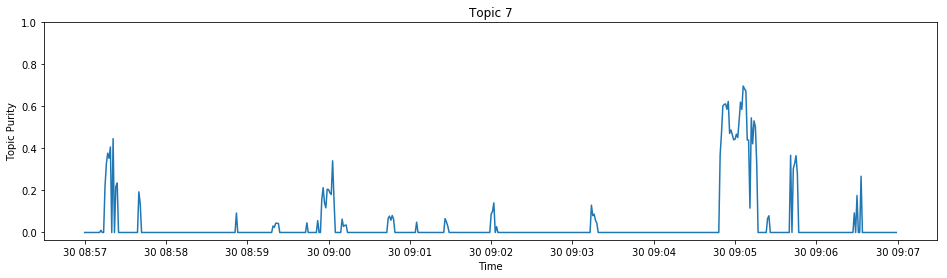

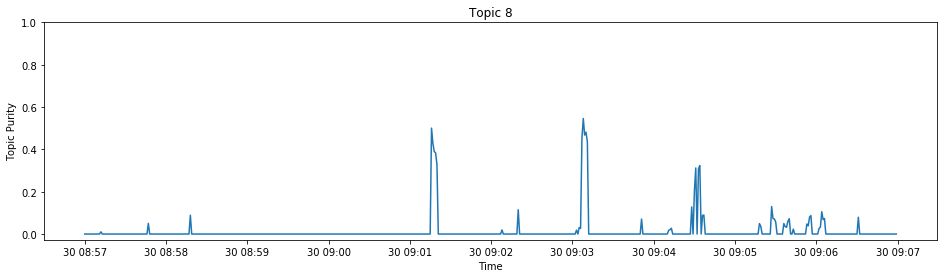

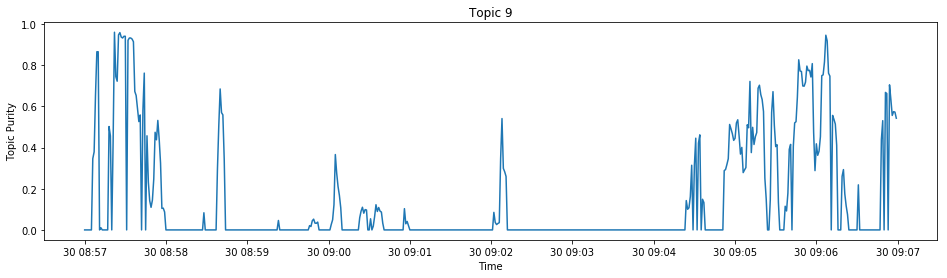

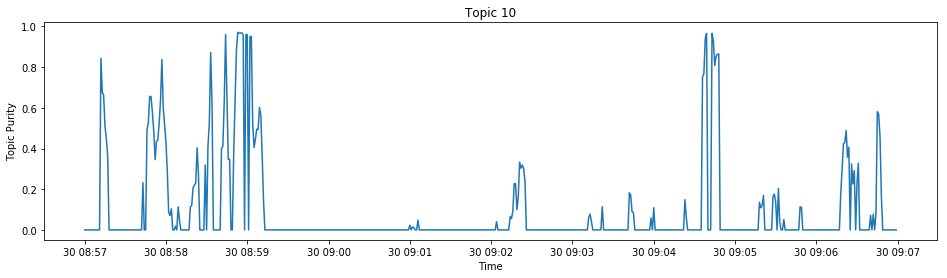

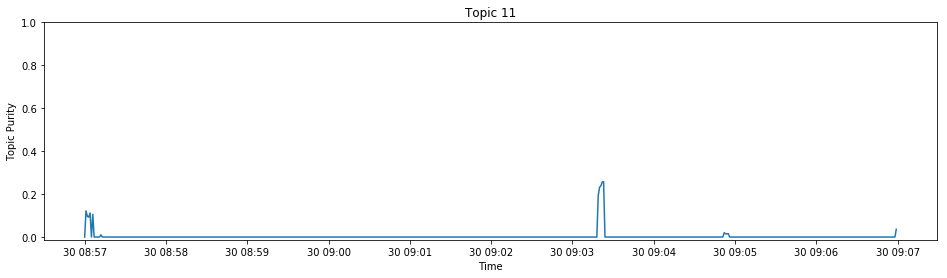

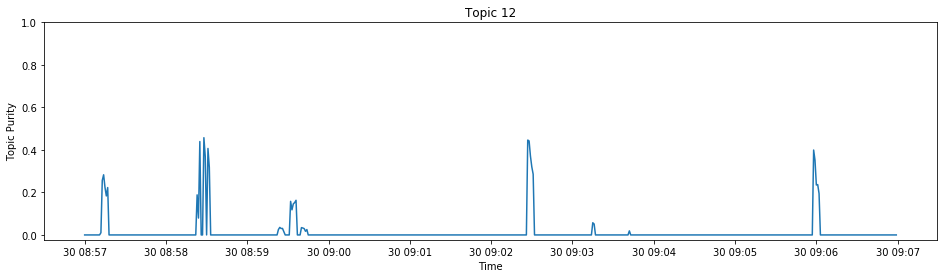

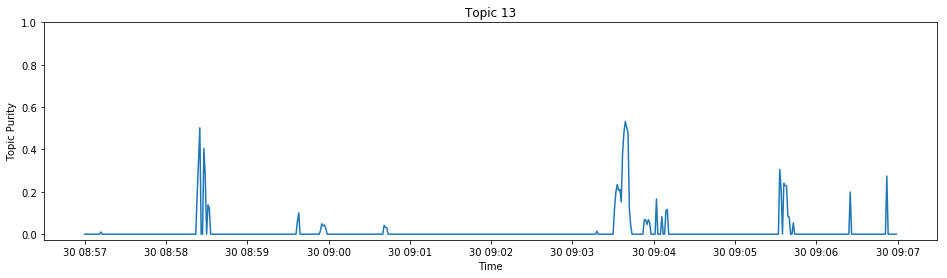

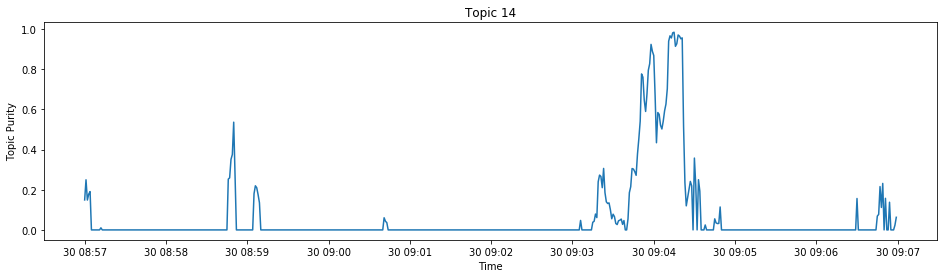

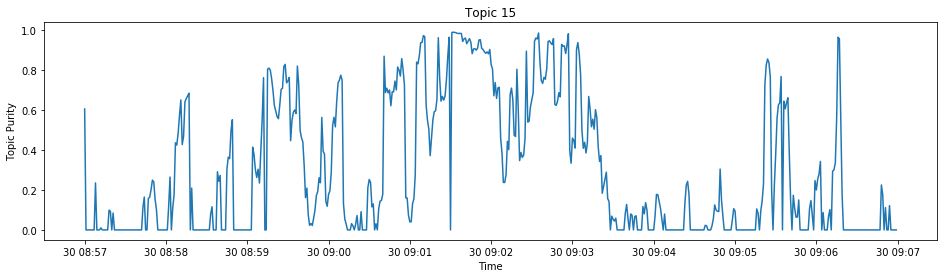

In [35]:
# Plot every topic. Not every single one contains
# meaningful insights but I plot them all here 
# anyways as a sanity check.

for i in range(lda_model.num_topics):
    
    plt.figure(figsize = (16,4))
    plt.plot(time_series[i][0:600])
    
    plt.xlabel("Time")
    plt.ylabel("Topic Purity")
    plt.title(f"Topic {i}")
    
    plt.yticks([0,0.2,0.4,0.6,0.8,1])

> These plots show the purity of each topic plotted out over the first ten minutes of the stream. Note that some are very sparse and some are very highly populated. Most of these will have some high spikes at various points in the VOD, however looking at these plots alone will give no information on the topic itself. LDA is a powerful tool, but it requires a human to look at the most common words and determine what the topic actually is.

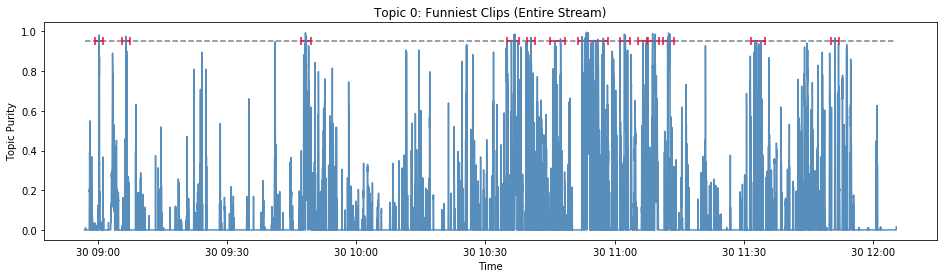

In [36]:
thresh = 0.95

time_series["highlight"] = (time_series[0] > thresh) * 1

plt.figure(figsize = (16,4))
plt.plot(time_series[0],
         c = "steelblue",
         alpha = 0.9)

plt.hlines(thresh, 
           time_series.index.min(), 
           time_series.index.max(), 
           colors = "k", 
           linestyles = "dashed",
           alpha = 0.5)

for clip in hl.get_highlights_timestamp(time_series, 
                                        before_time = 60, 
                                        after_time = 60):

    plt.hlines(thresh, 
               clip[0], 
               clip[1], 
               colors = "crimson")
    
    plt.vlines(clip[0], 
               thresh - 0.02, 
               thresh + 0.02, 
               colors = "crimson")
    
    plt.vlines(clip[1], 
               thresh - 0.02, 
               thresh + 0.02, 
               colors = "crimson")



plt.yticks([0,0.2,0.4,0.6,0.8,1]) 

plt.title("Topic 0: Funniest Clips (Entire Stream)")
plt.xlabel("Time")
plt.ylabel("Topic Purity");

> This plot shows the entire stream marked down with the funniest moments. Note that the topic was not automatically determined to be "the funny topic"; determining this required human intervention.

In [37]:
game = time_series["2019-04-30 10:29:26":"2019-04-30 11:14:00"]

game.head()

,mps,doc,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,highlight
2019-04-30 10:29:26,1,@AdmiralBulldog I can megasub but I wont 4Head,0.0,0.421818,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.532119,0.0,0.0,0.0,0.0,0.0,0
2019-04-30 10:29:27,0,,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0
2019-04-30 10:29:28,0,,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0
2019-04-30 10:29:29,0,,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0
2019-04-30 10:29:30,0,,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0


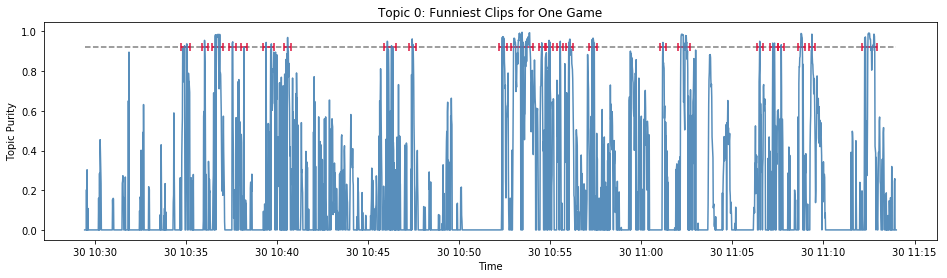

In [45]:
thresh = 0.92

game["highlight"] = (game[0] > thresh) * 1

plt.figure(figsize = (16,4))
plt.plot(game[0],
         c = "steelblue",
         alpha = 0.9)

plt.hlines(thresh, 
           game.index.min(), 
           game.index.max(), 
           colors = "k", 
           linestyles = "dashed",
           alpha = 0.5)

for clip in hl.get_highlights_timestamp(game, 
                                        before_time = 10, 
                                        after_time = 10):

    plt.hlines(thresh, 
               clip[0], 
               clip[1], 
               colors = "crimson")
    
    plt.vlines(clip[0], 
               thresh - 0.02, 
               thresh + 0.02, 
               colors = "crimson")
    
    plt.vlines(clip[1], 
               thresh - 0.02, 
               thresh + 0.02, 
               colors = "crimson")



plt.yticks([0,0.2,0.4,0.6,0.8,1]) 

plt.title("Topic 0: Funniest Clips for One Game")
plt.xlabel("Time")
plt.ylabel("Topic Purity");

plt.savefig("../assets/images/topic_modeling_single_game_funny.png");

> This plot shows that there are a quite a few moments where twitch chat was laughing collectively. 

In [39]:
hl.clip_stats(hl.get_highlights_timestamp(game,
                                          before_time = 10,
                                          after_time = 10))

24 distinct clips
11:24 total minutes of video


In [40]:
game[["highlight"]].to_csv("../data/highlighted/admiralbulldog_4_30_lda_funny.csv")

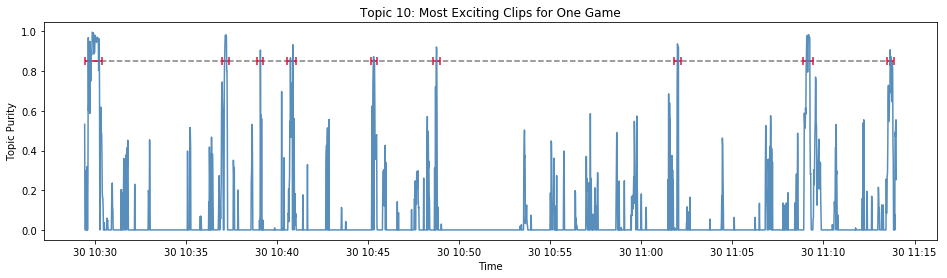

In [46]:
thresh = 0.85

game["highlight"] = (game[10] > thresh) * 1

plt.figure(figsize = (16,4))
plt.plot(game[10],
         c = "steelblue",
         alpha = 0.9)

plt.hlines(thresh, 
           game.index.min(), 
           game.index.max(), 
           colors = "k", 
           linestyles = "dashed",
           alpha = 0.5)

for clip in hl.get_highlights_timestamp(game, 
                                        before_time = 10, 
                                        after_time = 10):

    plt.hlines(thresh, 
               clip[0], 
               clip[1], 
               colors = "crimson")
    
    plt.vlines(clip[0], 
               thresh - 0.02, 
               thresh + 0.02, 
               colors = "crimson")
    
    plt.vlines(clip[1], 
               thresh - 0.02, 
               thresh + 0.02, 
               colors = "crimson")



plt.yticks([0,0.2,0.4,0.6,0.8,1]) 

plt.title("Topic 10: Most Exciting Clips for One Game")
plt.xlabel("Time")
plt.ylabel("Topic Purity");

plt.savefig("../assets/images/topic_modeling_single_game_exciting.png");

> The highlights for this topic are much sparser than the ones for the last topic. Perhaps this game was not so much a display of skill, but rather a comedy of errors?

In [42]:
hl.clip_stats(hl.get_highlights_timestamp(game,
                                          before_time = 10,
                                          after_time = 10))

9 distinct clips
4:9 total minutes of video


In [43]:
game[["highlight"]].to_csv("../data/highlighted/admiralbulldog_4_30_lda_exciting.csv")

---
[Back to top](#top)